In [128]:
%matplotlib inline

import numpy as np
#from car_met_hast_STU import car_lik
import math
from numpy.linalg import inv
import matplotlib
from scipy.stats import binom
from scipy.stats import gamma
from scipy.stats import laplace
from scipy.optimize import minimize
from scipy import integrate
from matplotlib import pyplot as plt

def car_lik(parameters,t,x,error_vars):

    error_vars = error_vars**2

    x = x.astype('float64')
    t = t.astype('float64')
    error_vars = error_vars.astype('float64')

    sigma = parameters[0]
    tau = parameters[1]

    #b = parameters[1] #comment it to do 2 pars estimation
    #tau = params(1,1);
    #sigma = sqrt(2*var(x)/tau);

    b = np.mean(x)/tau

    epsilon = 1e-300
    cte_neg = -np.infty
    num_datos = np.size(x)

    Omega = []
    x_hat = []
    a = []
    x_ast = []

    Omega.append((tau*(sigma**2))/2.)
    x_hat.append(0.)
    a.append(0.)
    x_ast.append(x[0] - b*tau)

    loglik = 0.

    for i in range(1,num_datos):

        a_new = np.exp(-(t[i]-t[i-1])/tau)
        x_ast.append(x[i] - b*tau)
        x_hat.append(a_new*x_hat[i-1] + (a_new*Omega[i-1]/(Omega[i-1] + error_vars[i-1]))*(x_ast[i-1]-x_hat[i-1]))

        Omega.append(Omega[0]*(1-(a_new**2)) + ((a_new**2))*Omega[i-1]*( 1 - (Omega[i-1]/(Omega[i-1]+ error_vars[i-1]))))

        loglik_inter = -0.5*( np.log(2*np.pi*(Omega[i] + error_vars[i])) + ((x_hat[i]-x_ast[i])**2) / (Omega[i] + error_vars[i]))
                       #+ np.log(epsilon)

        loglik = loglik + loglik_inter

    return loglik



In [129]:
def preprocess(text):
    lines = [line.strip().split(',') for line in open('lc_58.6272.729.B.txt')]
    lines = lines[1:]
    x = []
    t = []
    time_mean = 0
    mag_mean = 0
    error_mean = 0

    for i in lines:
        i[2] = float(i[2])
        error_mean += float(i[2])
    error_mean = error_mean/len(lines)
    
    outliers = 0
    #Quitar observaciones outliers
    for i in lines:
        if math.fabs(float(i[2])) > 3*math.fabs(error_mean):
            outliers += 1
            lines.remove(i)
            
    #Promedios de tiempo y magnitud
    for i in lines:
        i[0] = float(i[0])
        i[1] = float(i[1])
        t.append(i[0])
        x.append(i[1])
    t = np.asarray(t)
    x = np.asarray(x)
    
    max_t = max(t)
    min_t = min(t)
    for i in range(len(lines)):
        lines[i][0] = (lines[i][0] - min_t)/(max_t-min_t)
        lines[i][1] = (lines[i][1] - x.mean())/x.std()
    return lines

In [130]:
def fuct_wrapper(parameters,x,t,error):
    return -1*car_lik(parameters,x,t,error)

def nelder_mead(data):
    x0 = [0.001,0.01]
    x = []
    t = []
    error_args = []
    
    #Sacar información de data preprocesada
    for i in data:
        t.append(float(i[0]))
        x.append(float(i[1]))
        error_args.append(float(i[2]))
    
    x = np.asarray(x)
    t = np.asarray(t)
    error_args = np.asarray(error_args)
    mag_bound = 100
    #Para asegurar que no hayan problemas en el 0 los bounds no son desde 0.0
    res = minimize(fuct_wrapper, x0, args=(t,x,error_args), method='L-BFGS-B', bounds=((0.00001,mag_bound),(0.00001,1)))
    return res

Preprocesamiento de data y cálculo de sigma y tau usando L-BFGS-B

In [131]:
data = 'lc_58.6272.729.B.txt'
preprocess_data = preprocess(data)
res = nelder_mead(preprocess_data)
print(res)

      fun: 283.60958500971083
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.84217094e-05,  -2.84217094e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 183
      nit: 39
   status: 0
  success: True
        x: array([ 11.17513994,   0.01930005])


Valores de sigma y tau

In [132]:
sigma = res['x'][0]
tau = res['x'][1]

Usar data:

In [133]:
#Divide data
t = []
mag = []
error_args = []
for i in preprocess_data:
    t.append(i[0])
    mag.append(i[1])
    error_args.append(i[2])
t = np.asarray(t)
mag = np.asarray(mag)
error_args = np.asarray(error_args)

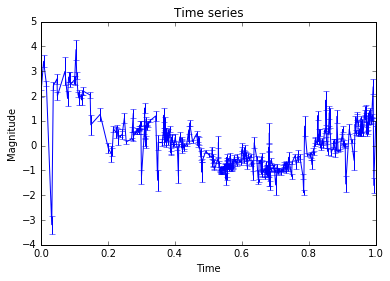

In [134]:
p = plt.errorbar(t, mag, yerr=error_args)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time series')


Calcular esperanza y varianzas según las fórmulas 

In [135]:
def ev_xt(x,t,mag,sigma,tau):
    #Esperanza y varianza de los puntos generados 
    e_xt = []
    v_xt = []
    b = np.mean(mag)/tau 

    #los i en x corresponden a los tiempos t
    for i in range(0,len(x)-1):
        s = [ n for n,j in enumerate(t) if j>x[i]][0] 
        s -= 1 #Buscar el tiempo anterior al primero que es más grande 
        delta_t = x[i] - t[s]
        e_xt.append( (np.exp(-delta_t/tau))*mag[s] + b*tau*(1-np.exp(-delta_t/tau)) )
        v_xt.append( ((tau*sigma**2)/2)*(1-np.exp(-2*(delta_t/tau))) )

    e_xt = np.asarray(e_xt)
    v_xt = np.asarray(v_xt)
    return e_xt, v_xt

Time series fit con los parámetros encontrados en la optimización

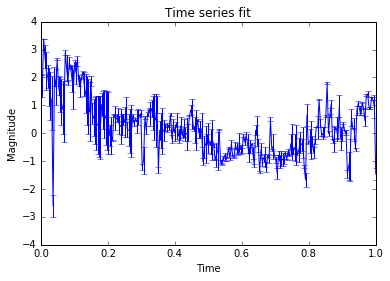

In [136]:
size = 250
x = np.linspace(0, 1, size)
e_v_xt= ev_xt(x,t,mag,sigma,tau)
e_xt = e_v_xt[0]
v_xt = e_v_xt[1]
x = np.linspace(0, 1, size-1)
p = plt.errorbar(x, e_xt, v_xt)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time series fit')



Time series raw (los datos graficados con sus errores)

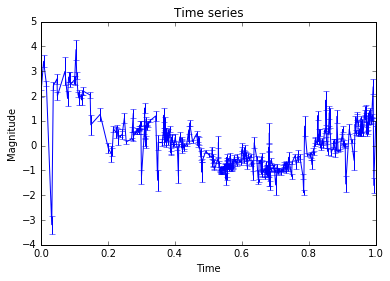

In [137]:
plt.errorbar(t, mag, yerr=error_args, capsize=3)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time series')

Time series + fit (ambos gráficos juntos sin us errores pues queda muy aglutinado)

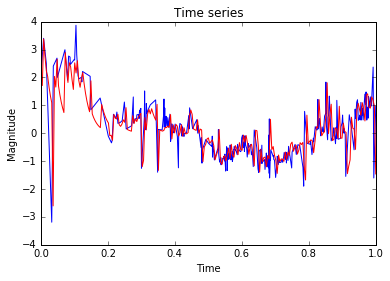

In [138]:
p = plt.plot(t, mag, 'b')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time series')
plt.plot(x, e_xt, 'r')

Utilizando Metropolis-Hastings

In [139]:
-

In [140]:
b_step = 100
s_window = 100
n = 2000 #Con 2000 corre rápido y da un resultado decente para testeo
sigma_samples, tau_samples = metropolis_multivariate(car_lik ,t ,mag ,error_args ,b_step ,s_window ,n)

sigma_mean = np.mean(sigma_samples)
tau_mean = np.mean(tau_samples)

print(sigma_mean)
print(tau_mean)

Porcentaje de aceptados: 0.0235
11.0651178028
0.0226293082371


Para Metropolis-Hasting modificado para este problema me ayudó mucho esta referencia http://stats.stackexchange.com/questions/137710/metropolis-hastings-using-log-of-the-density (para entender como hacerlo teniendo el log de la distribución). El método suele dar valores cercanos a los calculados por el método de optimización de parámetros (por alguna razón se aleja más para los valores de tau, puede ser por el burn in step y el sampleo bajo, un sampleo muy grande tardaba mucho tiempo).


Gráfico con el sigma y tau encontrados con Metropolis-Hasting

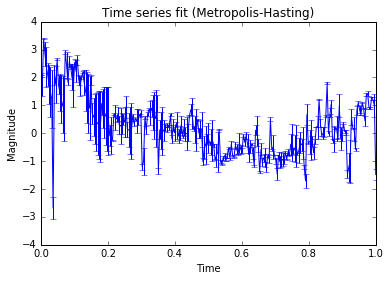

In [141]:
size = 250
x = np.linspace(0, 1, size)
e_v_xt= ev_xt(x,t,mag,sigma_mean,tau_mean)
e_xt = e_v_xt[0]
v_xt = e_v_xt[1]
x = np.linspace(0, 1, size-1)
p = plt.errorbar(x, e_xt, v_xt)
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Time series fit (Metropolis-Hasting)')

Gráfico de T(t)

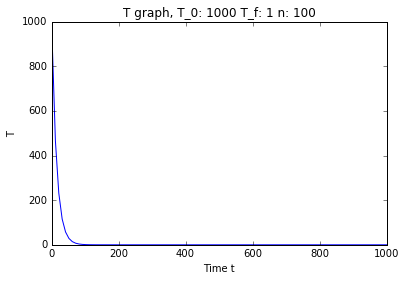

In [142]:
def graph_T(T_0,T_f,n):
    size = 100
    t = np.linspace(T_0, T_f, size)
    T = lambda t: T_0*(T_f/T_0)**(t/n)
    p = plt.plot(t, T(t), 'b')
    plt.xlabel('Time t')
    plt.ylabel('T')
    plt.title("T graph, T_0: " + str(T_0) + " T_f: " + str(T_f) + " n: " + str(n))

graph_T(1000,1,100)
#graph_T(100,1,100)
#graph_T(10,1,100)

Simulated Annealing 


In [143]:
def annealing_multivariate(p ,t ,mag ,error_args ,b_step ,s_window ,n):
    T_0 = 200
    T_f = 1
    n_1 = 1500
    #mag_bound = max(mag) - min(mag)
    T = lambda t: T_0*(T_f/T_0)**(t/n_1)
    x_t = [10,0.001]
    cov = [[1, 0], [0, 1]] #De la documentación
    log_likelihood = []
    samples = []
    samples2 = []
    aceptados = 0
    for i in range(0,n):
        while(True):
            x_star = np.random.multivariate_normal(x_t, cov, 1)[0]
            if x_star[0] > 0 and x_star[1] > 0 and x_star[1] <= 1:
                break
        
        T_t = max(T(i),T_f)
        q_factor = multivariate_normal(x_star, cov).pdf([1,0]) - multivariate_normal(x_t, cov).pdf([1,0])
        alpha = min( (1/T_t)*(p((x_star[0],x_star[1]),t ,mag , error_args)-p((x_t[0],x_t[1]),t ,mag , error_args) + q_factor)  ,0)
        flip = math.log(np.random.uniform(0,1))
            
        #Acceptance condition
        if(alpha >= flip): #Se cambia de dirección el símbolo de aceptación
            samples.append(x_star)
            log_likelihood.append(p((x_star[0],x_star[1]),t ,mag , error_args))
            x_t = x_star
            aceptados += 1
        else:
            samples.append(x_t)
    
    print("Porcentaje de aceptados: " + str(float(aceptados) / float(n)))
    #Burn in step
    samples = samples[b_step:]
    
    #Sampling window
    sigma_samples = []
    tau_samples = []
    

    
    for i in range(0,len(samples),s_window):
        sigma_samples.append(samples[i][0])
        tau_samples.append(samples[i][1])
    return sigma_samples, tau_samples, log_likelihood

Max likelihood, and likelihoods

In [145]:
b_step = 1
s_window = 1
n = 2000 #Con 2000 corre rápido y da un resultado decente para testeo
sigma_samples, tau_samples, log_likelihood = annealing_multivariate(car_lik ,t ,mag ,error_args ,b_step ,s_window ,n)
print("Max likelihood: " + str(max(log_likelihood)))
print("Likelihoods")
for i in log_likelihood:
    print(i)

Porcentaje de aceptados: 0.4855
Max likelihood: -283.676672281
Likelihoods
-298.682879227
-331.174899842
-314.252186458
-299.71102494
-303.365287997
-309.730451264
-312.031040304
-317.749056342
-304.449438429
-302.12669825
-295.355343642
-296.173221295
-296.320358094
-298.791479564
-296.773670892
-291.342806808
-295.644563723
-294.518854994
-297.13801155
-296.359731338
-294.453361283
-295.923528534
-296.20276978
-299.731005495
-307.112822578
-289.39011612
-299.497945031
-297.433194489
-307.885131903
-302.978760675
-305.104086351
-300.777698718
-294.854397439
-294.191159792
-290.864009679
-295.160702095
-296.425768386
-305.518106209
-292.228799733
-300.898118373
-300.229292276
-300.638463041
-315.74756813
-324.793337941
-328.795656049
-407.290576498
-597.625001422
-608.626537263
-419.637377446
-368.162858481
-350.918826343
-349.215016449
-311.390694499
-312.565830501
-328.745938319
-322.527805132
-307.52135891
-305.278559613
-300.533459185
-321.583678277
-307.333356214
-301.219055087
-3

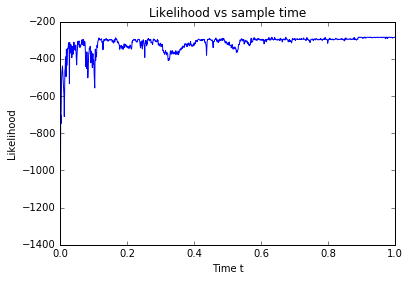

In [124]:
size = len(log_likelihood)
t = np.linspace(0, 1, size)
p = plt.plot(t, log_likelihood, 'b')
plt.xlabel('Time t')
plt.ylabel('Likelihood')
plt.title("Likelihood vs sample time")

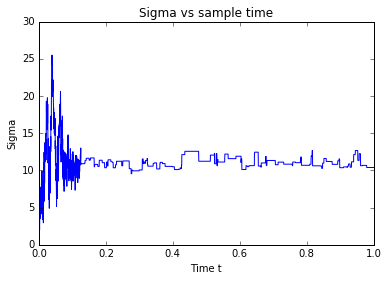

In [125]:
size = len(sigma_samples)
t = np.linspace(0, 1, size)
p = plt.plot(t, sigma_samples, 'b')
plt.xlabel('Time t')
plt.ylabel('Sigma')
plt.title("Sigma vs sample time")

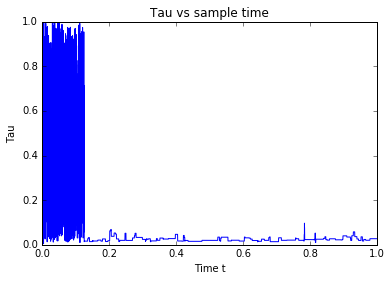

In [126]:
size = len(tau_samples)
t = np.linspace(0, 1, size)
p = plt.plot(t, tau_samples, 'b')
plt.xlabel('Time t')
plt.ylabel('Tau')
plt.title("Tau vs sample time")